# LSTM_V1

In [1]:
!pip install gaft

In [2]:
# import models
import numpy as np
import pickle
from gaft import GAEngine
from gaft.components import BinaryIndividual, Population
from gaft.operators import RouletteWheelSelection, UniformCrossover, FlipBitMutation

import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.callbacks import EarlyStopping
# from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers import Dense,LSTM,Dropout
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, roc_curve, auc, precision_recall_curve, confusion_matrix,ConfusionMatrixDisplay,recall_score,f1_score, explained_variance_score,precision_score
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('fivethirtyeight')

# import and Clean Data

In [3]:

# Read the data
df = pd.read_csv('/kaggle/input/simulation-dataset3/resources.csv')
df.set_index('TaskID', inplace=True)
# Display results
# print(df.head())
print(df.info())


data1 =[[ 0.2 ,125 ,88 ,3000 ,8 ,9 , 15 ,4 ,150051 ,0.3 ,1541 ,1256,12003.15 ]]
df1 = pd.DataFrame(data1, columns=['StartTime', 'TaskFileSize', 'TaskOutputFileSize', 'TaskFileLength', 'DistanceFromDataCenter', 'DataCenterCpuCost', 'DataCenterRamCost', 'DataCenterStorageCost', 'DataCenterBwCost', 'DataCenterTotalLoad', 'NetworkDelay', 'CET', 'ObjectiveFunction'])

<class 'pandas.core.frame.DataFrame'>
Index: 900 entries, 4 to 900
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   StartTime               900 non-null    float64
 1   TaskFileSize            900 non-null    int64  
 2   TaskOutputFileSize      900 non-null    int64  
 3   TaskFileLength          900 non-null    int64  
 4   DistanceFromDataCenter  900 non-null    float64
 5   DataCenterCpuCost       900 non-null    float64
 6   DataCenterRamCost       900 non-null    float64
 7   DataCenterStorageCost   900 non-null    float64
 8   DataCenterBwCost        900 non-null    float64
 9   DataCenterTotalLoad     900 non-null    float64
 10  NetworkDelay            900 non-null    float64
 11  CET                     900 non-null    float64
 12  ObjectiveFunction       900 non-null    float64
 13  DataCenterID            900 non-null    int64  
dtypes: float64(10), int64(4)
memory usage: 105.5 KB

## plot the data

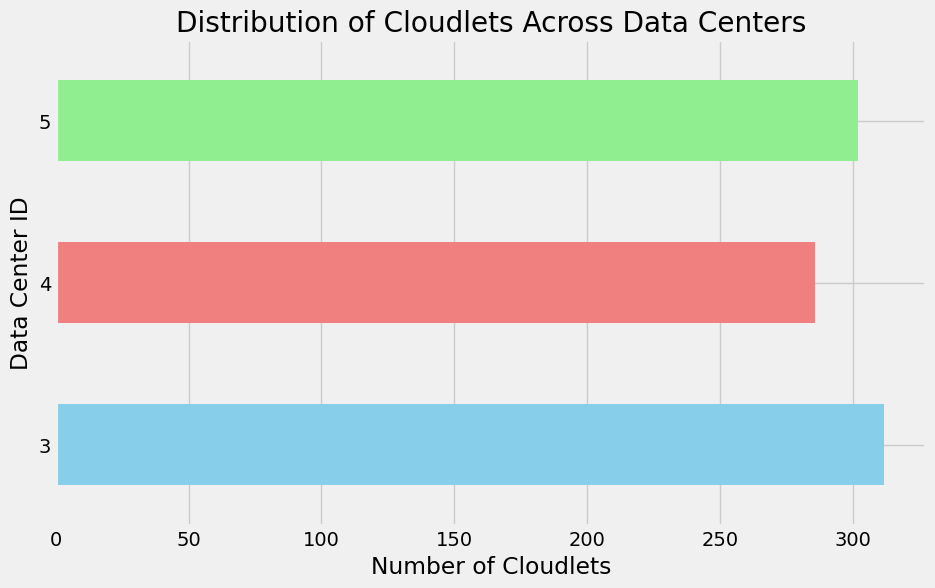

In [4]:
cloudlets_count = df['DataCenterID'].value_counts()

# Define a color for each bar
colors = ['skyblue', 'lightcoral', 'lightgreen']

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
cloudlets_count.sort_index().plot(kind='barh', color=colors)
plt.title('Distribution of Cloudlets Across Data Centers')
plt.xlabel('Number of Cloudlets')
plt.ylabel('Data Center ID')
plt.show()

## Scale the data

In [5]:
labels = df['DataCenterID']
features = df.drop('DataCenterID', axis=1)  # Drop the label column
# Apply MinMaxScaler to scale only the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
# Combine the scaled features with the labels
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df['DataCenterID'] = labels
scaled_df = scaled_df.iloc[1:]
# print(scaled_df.head())

# create windows (Input Function)

In [6]:
X = scaled_df.drop('DataCenterID', axis=1)
y = scaled_df['DataCenterID']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps), :].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24  # Define your time_steps size
X_train, y_train = create_dataset(X_train, y_train, time_steps)
X_test, y_test = create_dataset(X_test, y_test, time_steps)

print(X_train.shape,"++",y_train.shape,"++",X_test.shape,"++",y_test.shape)

(695, 24, 13) ++ (695,) ++ (156, 24, 13) ++ (156,)


perform LSTM model

In [7]:
from keras.utils import to_categorical
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dropout

y_train_adjusted = y_train - 3
y_test_adjusted = y_test - 3
y_train_categorical = to_categorical(y_train_adjusted)
y_test_categorical = to_categorical(y_test_adjusted)
num_classes = len(np.unique(labels))#3

print("X_train shape before reshape:", X_train.shape)

X_train shape before reshape: (695, 24, 13)


In [8]:
# Increase the complexity of the model
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128, activation='relu',return_sequences=False)) # Change activation function
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax')) # Change activation function

optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)

history = model.fit(
  X_train, y_train_categorical,
  epochs=50, # Increase the number of epochs
  batch_size=12,
  validation_split=0.1,
  shuffle=False,
  verbose=1,
  
callbacks=[early_stopping] 
)

Epoch 1/50
53/53 [==============================] - 7s 67ms/step - loss: 1.3040 - accuracy: 0.3424 - val_loss: 1.1110 - val_accuracy: 0.3429
Epoch 2/50
53/53 [==============================] - 3s 56ms/step - loss: 1.1880 - accuracy: 0.3456 - val_loss: 1.1758 - val_accuracy: 0.3571
Epoch 3/50
53/53 [==============================] - 3s 58ms/step - loss: 1.1294 - accuracy: 0.3824 - val_loss: 1.1531 - val_accuracy: 0.4000
Epoch 4/50
53/53 [==============================] - 3s 57ms/step - loss: 1.1349 - accuracy: 0.3856 - val_loss: 1.0930 - val_accuracy: 0.4143
Epoch 5/50
53/53 [==============================] - 3s 57ms/step - loss: 1.1003 - accuracy: 0.3936 - val_loss: 1.2120 - val_accuracy: 0.4000
Epoch 6/50
53/53 [==============================] - 3s 56ms/step - loss: 1.0596 - accuracy: 0.4400 - val_loss: 1.1474 - val_accuracy: 0.4000
Epoch 7/50
53/53 [==============================] - 3s 57ms/step - loss: 1.0446 - accuracy: 0.4832 - val_loss: 1.2031 - val_accuracy: 0.4143
Epoch 8/50
53

In [9]:

data1 =[[ 0.2 ,125 ,88 ,3000 ,8 ,9 , 15 ,4 ,150051 ,0.3 ,1541 ,1256,12003.15 ]]
df1 = pd.DataFrame(data1, columns=['StartTime', 'TaskFileSize', 'TaskOutputFileSize', 'TaskFileLength', 'DistanceFromDataCenter', 'DataCenterCpuCost', 'DataCenterRamCost', 'DataCenterStorageCost', 'DataCenterBwCost', 'DataCenterTotalLoad', 'NetworkDelay', 'CET', 'ObjectiveFunction'])

In [10]:
# Increase the complexity of the model
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(128, activation='relu',return_sequences=False)) # Change activation function
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax')) # Change activation function

optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
history = model.fit(
  X_train, y_train_categorical,
  epochs=50, # Increase the number of epochs
  batch_size=12,
  validation_split=0.1,
  shuffle=False,
  verbose=1, 
callbacks=[early_stopping] 
)

Epoch 1/50
53/53 [==============================] - 7s 70ms/step - loss: 1.2743 - accuracy: 0.3760 - val_loss: 2.9124 - val_accuracy: 0.3429
Epoch 2/50
53/53 [==============================] - 3s 61ms/step - loss: 1.1350 - accuracy: 0.3440 - val_loss: 4.6812 - val_accuracy: 0.3429
Epoch 3/50
53/53 [==============================] - 3s 63ms/step - loss: 1.1259 - accuracy: 0.3136 - val_loss: 1.4793 - val_accuracy: 0.4000
Epoch 4/50
53/53 [==============================] - 3s 56ms/step - loss: 1.1150 - accuracy: 0.3312 - val_loss: 1.1602 - val_accuracy: 0.4000
Epoch 5/50
53/53 [==============================] - 3s 58ms/step - loss: 1.1014 - accuracy: 0.3296 - val_loss: 1.1707 - val_accuracy: 0.4000
Epoch 6/50
53/53 [==============================] - 3s 56ms/step - loss: 1.0956 - accuracy: 0.3456 - val_loss: 1.1695 - val_accuracy: 0.4000
Epoch 7/50
53/53 [==============================] - 3s 56ms/step - loss: 1.0843 - accuracy: 0.3744 - val_loss: 1.4936 - val_accuracy: 0.4000
Epoch 8/50
53

5/5 [==============================] - 0s 30ms/step - loss: 5.6053 - accuracy: 0.3077
Test Accuracy: 0.3076923191547394
5/5 [==============================] - 1s 27ms/step


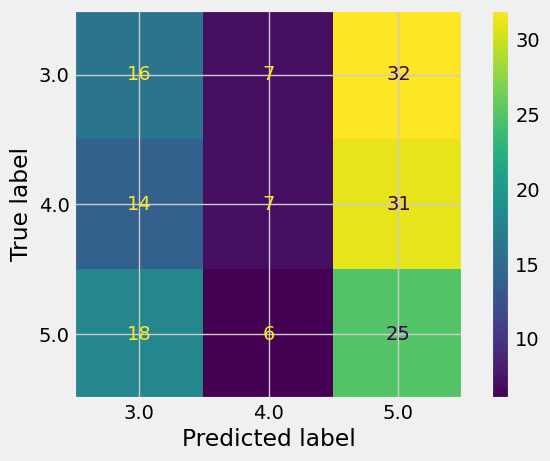

In [11]:

accuracy = model.evaluate(X_test, y_test_categorical)
print(f'Test Accuracy: {accuracy[1]}')

# Make predictions on the test data
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)+3
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()
plt.show()

## implement GA

In [12]:
def decode(indv):
    # Decode number of LSTM units, e.g., from a 7-bit encoding
    n_units =max(1, int(''.join(map(str, indv.chromsome[:7])), 2))

    # Decode depth of network from a 3-bit encoding
    depth = int(''.join(map(str, indv.chromsome[7:10])), 2)

    # Decode activation function
    act_bits = ''.join(map(str, indv.chromsome[10:12]))
    if act_bits == '00':
        activation = 'relu'
    elif act_bits == '01':
        activation = 'tanh'
    else:
        activation = 'sigmoid'
    
    # Decode optimizer
    opt_bits = ''.join(map(str, indv.chromsome[12:14]))
    if opt_bits == '00':
        optimizer = 'adam'
    elif opt_bits == '01':
        optimizer = 'sgd'
    else:
        optimizer = 'rmsprop'
    
    # Decode learning rate (assuming a fixed value from the chromosome, you can adapt this as needed)
    lr = float(indv.chromsome[14]) / 10  # Convert to a range between 0.0 to 1.0

    return n_units, depth, activation, optimizer, lr

    
def fitness_function(indv):
    
    # Decode GA individual to LSTM parameters
    n_units, depth, activation, optimizer, lr = decode(indv)
    
    # Create and train LSTM model
    model = create_model(n_units, depth, activation, optimizer, lr)
    model.fit(X_train, y_train, batch_size=60, verbose=0)

    # Calculate prediction error (MSE)
    y_pred = model.predict(X_test)
    mse = np.mean(np.square(y_test - y_pred))
    mse=np.round(mse,4)
    print(f"Units: {n_units}, Depth: {depth}, Activation: {activation}, Optimizer: {optimizer}, Learning Rate: {lr} Mean Squared Error: {mse}")
    
    # Since GA is maximizing and we want to minimize MSE, return negative MSE
    
    return -mse

def run_ga_engine():
    # Create GA engine
    print("GA Optimization Algorithm  Started...")
    population_size=4
    indv_template = BinaryIndividual(ranges=[(0, 100), (0, 100)], eps=0.001)
    population = Population(indv_template=indv_template, size=population_size).init()

    selection = RouletteWheelSelection()
    crossover = UniformCrossover(pc=0.8, pe=0.5)
    mutation = FlipBitMutation(pm=0.1)

    engine = GAEngine(population=population, selection=selection,
                      crossover=crossover, mutation=mutation,
                      fitness=fitness_function)
    
    # Run GA engine
    engine.run(ng=2)  # Run GA for 2 generations
    best_indv = engine.population.best_indv(engine.fitness)
    best_fitness =-1* engine.fitness(best_indv)
    n_units, depth, activation, optimizer, lr = decode(best_indv)
    
    
    print("Best Individual Solution:", best_indv.solution)
    print("Best Fitness:", best_fitness)
    print(f"Units: {n_units}, Depth: {depth}, Activation: {activation}, Optimizer: {optimizer}, Learning Rate: {lr}")
    
run_ga_engine()
lstm_model = create_model(34, 2, "relu", "adam", "lr", 24, 1)


print("GA Optimization Algorithm  Finished. ")

GA Optimization Algorithm  Started...


NameError: name 'create_model' is not defined

## find regression metrics

In [ ]:
def GetRegressionMetrics(y_true, y_pred):
    # Compute regression metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = round(mse, 3)
    rmse = round(rmse, 3)
    mae = round(mae, 3)
    mape = round(mape, 3)
   
    metrics = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}
   
    return metrics
true=y_test
reg_metrics = GetRegressionMetrics(true, predicted)

## plot regression metrics

In [ ]:
print(reg_metrics)
x1 = np.arange(len(reg_metrics))
plt.bar(x1, reg_metrics.values(), width=0.50, label='CNN Model')
plt.xticks([x for x in x1], reg_metrics.keys())
plt.legend()
plt.show()